# Monte Carlo Simulation

In [2]:
# Initial imports
import os
import requests
import pandas as pd
import numpy as np
!pip install alpaca_trade_api
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv

load_dotenv()

%matplotlib inline

     |████████████████████████████████| 40 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 102 kB 10.0 MB/s ta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
# Set Alpaca API key and secret
alpaca_api_key = "PKMWQL1LA14C1RK0ZTTC"
alpaca_secret_key = "OnzURrqiO6snAtKkNF9K15QQQrQ4YTAi5w211ZhD"

api = tradeapi.REST(alpaca_api_key,
                    alpaca_secret_key,
                    api_version='v2')

## Fetch Tickers Data

In [4]:
def get_ticker_prices(ticker):
    
    # Set timeframe to '1D'
    timeframe = '1D'

    # Make the API cal and store in DataFrame    
    data_df = api.get_barset(ticker,
                             timeframe,
                             limit=None,
                             after=None,
                             until=None).df
    
    # Clean DataFrame to show only close prices 
    df = pd.DataFrame({'close_'+ticker.lower():data_df[ticker]['close']})
    return df

In [5]:
# Obtain ticker prices, join data and display preview
spy_data = get_ticker_prices("SPY")

agg_data = get_ticker_prices("AGG")

tickers_data = spy_data.join(agg_data)

tickers_data.head()

,close_spy,close_agg
time,,
2021-03-15 00:00:00-04:00,396.47,113.94
2021-03-16 00:00:00-04:00,395.94,113.87
2021-03-17 00:00:00-04:00,397.22,113.87
2021-03-18 00:00:00-04:00,391.41,113.42
2021-03-19 00:00:00-04:00,389.50,113.50


## Monte Carlo Simulation Code

In [6]:
# Calculate the daily roi for the stocks
daily_returns = tickers_data.pct_change()
print("*" * 100)
print("Daily ROI")
display(daily_returns.head())

# volatility
daily_volatility = daily_returns.std()
spy_volatility = daily_volatility["close_spy"]
agg_volatility = daily_volatility["close_agg"]

# Save the last day's closing price
spy_last_price = tickers_data["close_spy"][-1]
agg_last_price = tickers_data["close_agg"][-1]

****************************************************************************************************
Daily ROI


,close_spy,close_agg
time,,
2021-03-15 00:00:00-04:00,NaN,NaN
2021-03-16 00:00:00-04:00,-0.001337,-0.000614
2021-03-17 00:00:00-04:00,0.003233,0.000000
2021-03-18 00:00:00-04:00,-0.014627,-0.003952
2021-03-19 00:00:00-04:00,-0.004880,0.000705


In [7]:
# Setup the Monte Carlo Parameters
number_simulations = 10
number_records = 252 * 30  # Years to retirement
monte_carlo = pd.DataFrame()

In [8]:
for x in range(number_simulations):

    print(f"Running Simulation {x}...")

    # Create the initial simulated prices array seeded with the last closing price
    spy_prices = [spy_last_price]
    agg_prices = [agg_last_price]

    # Simulate the returns for 20 years
    for iteration in range(number_records):
        spy_prices.append(spy_prices[-1] * (1 + np.random.normal(daily_returns.mean()["close_spy"], spy_volatility)))
        agg_prices.append(agg_prices[-1] * (1 + np.random.normal(daily_returns.mean()["close_agg"], agg_volatility)))

    # Create a DataFrame of the simulated prices
    portfolio = pd.DataFrame({"SPY Simulated Prices": spy_prices,
                              "AGG Simulated Prices": agg_prices})

    # Calculate the Portfolio Daily Returns
    portfolio_returns = portfolio.pct_change()

    # Set the Portfolio Weights (Assume a 60/40 stocks to bonds ratio)
    stocks_weight = 0.60
    bonds_weight = 0.40

    # Calculate the weighted portfolio return:
    portfolio_returns = (stocks_weight * portfolio_returns["SPY Simulated Prices"]
        + bonds_weight * portfolio_returns["AGG Simulated Prices"])
    

    # Calculate the normalized, cumulative return series
    monte_carlo[x] = (1 + portfolio_returns.fillna(0)).cumprod()

Running Simulation 0...
Running Simulation 1...
Running Simulation 2...
Running Simulation 3...
Running Simulation 4...
Running Simulation 5...
Running Simulation 6...
Running Simulation 7...
Running Simulation 8...
Running Simulation 9...


In [9]:
# Check that the simulation ran successfully
monte_carlo.head()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007749,1.003549,0.995268,1.004272,0.993752,1.009321,0.995562,0.995986,0.993434,1.001577
2,1.015461,1.000433,1.000765,1.012307,0.996441,1.008851,1.000052,0.997621,0.988793,1.000058
3,1.018109,1.005802,1.002997,1.010153,0.999592,1.007602,1.005215,1.000657,0.986545,0.998075
4,1.012363,1.011333,0.999385,1.009141,0.997093,1.006298,1.010289,1.001341,0.984752,1.000282


<AxesSubplot:title={'center':'Simulated Retirement Portfolio'}>

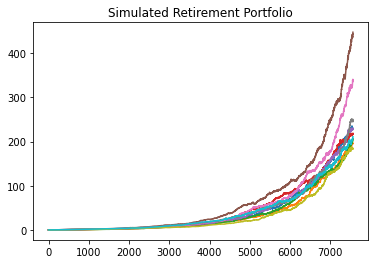

In [10]:
# Visualize the Simulation
monte_carlo.plot(legend=None,
                 title="Simulated Retirement Portfolio")